In the last notebook we ended up with simple FCN. Now let's compare it with implementation that is used in PyTorch.

In [4]:
%load_ext autoreload
%autoreload 2

import math
import torch
from importer import import_from_nb

make_dataset = import_from_nb('2.1', 'make_dataset')
Sequential = import_from_nb('2.2', 'Sequential')
LinearLayer = import_from_nb('2.2', 'LinearLayer')
SigmoidActivation = import_from_nb('2.2', 'SigmoidActivation')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


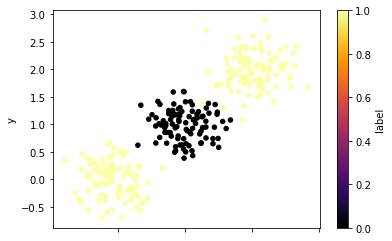

In [5]:
X, y = make_dataset('hard')

Our latest model is defined by

In [6]:
hidden = 4
epochs = 50
learning_rate = 0.4

sigmoid = SigmoidActivation()
model = Sequential([LinearLayer((2, hidden), sigmoid),
                    LinearLayer((hidden, hidden), sigmoid),
                    LinearLayer((hidden, 1), sigmoid)])

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_hat = model(X_batch)
        errors = y_batch - y_hat

        model.back(errors)
        model.step(learning_rate)

assert torch.mean(torch.abs(errors)) < 0.05

Let's recreate the same FCN in PyTorch.

In [7]:
loss_fn = torch.nn.MSELoss(reduction='sum')
model = torch.nn.Sequential(
    torch.nn.Linear(2, hidden), torch.nn.Sigmoid(),
    torch.nn.Linear(hidden, hidden), torch.nn.Sigmoid(),
    torch.nn.Linear(hidden, 1), torch.nn.Sigmoid())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
assert torch.mean(torch.abs(y_pred - y_batch)) < 0.05

Major difference from what we have is that tensors contain param `requires_grad`, that tells autograd to begin recording operations on a Tensor. This allows to control which of those are trainable and enables nice decoupling of optimizer.

In [8]:
a = torch.tensor([2.], requires_grad=True)
b = a**3
b.backward()
assert a.grad == 12.
assert a.is_leaf
assert not b.is_leaf

Under the hood (on C++ level) pytorch stores the graph of operations. It's hard to backtrack what is going on, but autograd knows about gradients from this map - https://github.com/pytorch/pytorch/blob/3fe4718d164b4231684ff995ba13ca0d91d59c6d/tools/autograd/derivatives.yaml. So let's review our backward step and instead of returning gradients let's store them in weight matrices. In this case `self.diff` becomes `self.out.grad` and our return diff is saved as `self.inp.grad`. When refactoring in such way we do not need to pass any multiplier to back call since that one will be already stored in `self.out.grad`. To add `errors` we will add AbsLoss to the model itself.

If you extract what is going on step by step here on back call you get
```python
inp.grad = inp - true
inp.grad = out.grad * inp * (1 - inp)
inp.grad = out.grad @ W.T
inp.grad = out.grad * inp * (1 - inp)
inp.grad = out.grad @ W.T
inp.grad = out.grad * inp * (1 - inp)
inp.grad = out.grad @ W.T
```
that represents same approach we started with
```python
diff_3 = errors * diff(L_3)
diff_2 = diff_3 @ W_2.T * diff(L_2) 
diff_1 = diff_2 @ W_1.T * diff(L_1) 
```

In [9]:
class SigmoidActivation():
    def __call__(self, x):
        self.inp = x
        self.out = torch.sigmoid(x)
        return self.out
    
    def back(self):
        self.inp.grad = self.out.grad * self.out * (1 - self.out)
    
    def step(self, lr):
        return
    

class LinearLayer():
    def __init__(self, shape):
        self.W = torch.randn(shape) / math.sqrt(shape[0])
        self.b = torch.zeros((shape[1]))
        self.inp = None
        self.out = None
    
    def __call__(self, x):
        self.inp = x
        self.out = x @ self.W + self.b
        return self.out

    def back(self):
        self.inp.grad = self.out.grad @ self.W.T
        self.W.grad = self.inp.T @ self.out.grad
        self.b.grad = self.out.grad.sum(0)

    def step(self, learning_rate):
        self.W -= learning_rate * self.W.grad
        self.b -= learning_rate * self.b.grad


class Sequential():
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss
    
    def __call__(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x, y)
    
    def back(self):
        self.loss.back()
        for l in reversed(self.layers): l.back()
    
    def step(self, lr):
        for l in self.layers: l.step(lr)

            
class AbsLoss():
    def __call__(self, pred, true):
        self.inp = pred
        self.true = true
        return torch.mean(torch.abs(pred - true))

    def back(self):
        self.inp.grad = self.inp - self.true

In [10]:
hidden = 4
epochs = 50
learning_rate = 0.4

model = Sequential([LinearLayer((2, hidden)),      SigmoidActivation(),
                    LinearLayer((hidden, hidden)), SigmoidActivation(),
                    LinearLayer((hidden, 1)),      SigmoidActivation()], AbsLoss())

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        loss = model(X_batch, y_batch)

        model.back()
        model.step(learning_rate)

assert loss < 0.05

From here we can add Optimizer instead of using step.

In [11]:
class Optimizer():
    def __init__(self, params):
        self.params = params
    
    def step(self, lr):
        for p in self.params:
            p -= lr * p.grad

            
class SigmoidActivation():
    def __call__(self, x):
        self.inp = x
        self.out = torch.sigmoid(x)
        return self.out
    
    def back(self):
        self.inp.grad = self.out.grad * self.out * (1 - self.out)
    

class LinearLayer():
    def __init__(self, shape):
        self.W = torch.randn(shape) / math.sqrt(shape[0])
        self.b = torch.zeros((shape[1]))
        self.params = [self.W, self.b]
        self.inp = None
        self.out = None
    
    def __call__(self, x):
        self.inp = x
        self.out = x @ self.W + self.b
        return self.out

    def back(self):
        self.inp.grad = self.out.grad @ self.W.T
        self.W.grad = self.inp.T @ self.out.grad
        self.b.grad = self.out.grad.sum(0)


class Sequential():
    def __init__(self, layers, loss):
        self.layers = layers
        self.params = [p for l in layers if hasattr(l, 'params') for p in l.params]
        self.loss = loss
    
    def __call__(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x, y)
    
    def back(self):
        self.loss.back()
        for l in reversed(self.layers): l.back()

            
class AbsLoss():
    def __call__(self, pred, true):
        self.inp = pred
        self.true = true
        return torch.mean(torch.abs(pred - true))

    def back(self):
        self.inp.grad = self.inp - self.true

In [12]:
hidden = 4
epochs = 50
learning_rate = 0.4

model = Sequential([LinearLayer((2, hidden)),      SigmoidActivation(),
                    LinearLayer((hidden, hidden)), SigmoidActivation(),
                    LinearLayer((hidden, 1)),      SigmoidActivation()], AbsLoss())
opt = Optimizer(model.params)

for _ in range(epochs):
    for batch in range(10):
        X_batch = X[batch * 30:(1 + batch) * 30]
        y_batch = y[batch * 30:(1 + batch) * 30]

        loss = model(X_batch, y_batch)

        model.back()
        opt.step(learning_rate)

assert loss < 0.05

Even though still basic, this implementation is already close to PyTorch way.

# Next steps

As the next step it would be nice to add simple callback and track weights during training.

PyTorch Linear layer init uses kaiming weights and bounded bias:
```python
init.kaiming_uniform_(self.weight, a=math.sqrt(5))
if self.bias is not None:
    fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)
```